In [ ]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install tensorflow_addons==0.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
tf_utils = tf.keras.utils

In [ ]:
#import keras.api._v2.keras as keras

In [ ]:
#from keras.layers import Layer

In [ ]:
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

In [ ]:
num_class = 10
input_shape= (32,32,3)

(x_train, y_train), (x_test,y_test)= keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_test.shape}")
print(f"x_test shape: {x_test.shape} - y_train shape: {y_test.shape}")


170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (10000, 1)
x_test shape: (10000, 32, 32, 3) - y_train shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.001
batch_size= 256
num_epochs = 40
image_size = 72 #resizing input images
patch_size = 6
num_patches= (image_size//patch_size)**2
projection_dim= 64
num_heads = 4
transformer_units = [
    projection_dim*2,
    projection_dim
    ]                     #size of transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]   #size of dense layers of the final classifier



# Data augmentation pipeline

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.Normalization(),
      layers.Resizing(image_size, image_size),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(factor=0.02),
      layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)       #compute mean and variance of x_train

In [ ]:
def mlp(x, hidden_units, dropout_rate):     #multi layer perceptrons
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x= layers.Dropout(dropout_rate)(x)          #sets fraction of input to 0
  return x

# Creating patches

In [ ]:
class Patches(layers.Layer):
  def __init__(self,patch_size):         #constructor
    super(Patches, self).__init__()
    self.patch_size =patch_size


  def call(self, images):
    batch_size = tf.shape(images)[0]          #will dynamically determine the batch size at run time
    patches = tf.image.extract_patches(
        images=images,
        sizes= [1,self.patch_size, self.patch_size, 1],
        strides =  [1,self.patch_size, self.patch_size, 1],    #step size between patches
        rates=[1,1,1,1],                     #dilation rates...........1 means no dilation
        padding= "VALID",
    )

    patch_dims=patches.shape[-1]              #will flatten the patch so that each image is presented as seq of patches
    patches = tf.reshape(patches, [batch_size, -1,patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


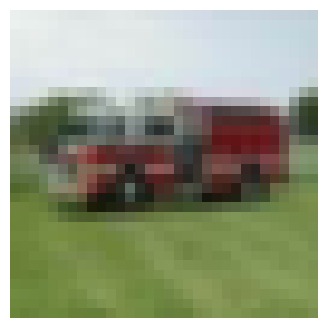

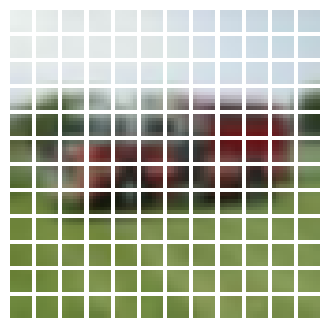

In [ ]:
plt.figure(figsize=(4,4))
image= x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches= Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n= int(np.sqrt(patches.shape[1]))
plt.figure(figsize= (4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

# Patch encoding

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches= num_patches
    self.projection = layers.Dense(units= projection_dim)       #performs linear projection of input patches to lower dimensions specified by proj dim
    self.position_embedding = layers.Embedding(         #instance of layer embedding        #embedding layer is a layer in Neural networks that maps the input info from from higher dimension to o/p layer (lower dim) allowing network to learn more about the relation between inputs to process data more efficiently
      input_dim = num_patches, output_dim = projection_dim
    )

  def call(self,patch):
    positions = tf.range(start=0, limit= self.num_patches, delta=1)     #to generate tensors of seq num from 0 to range......will represent the index of each patch
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded


In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape= input_shape)
  #Augment data
  augmented = data_augmentation(inputs)
  #Create patches
  patches = Patches(patch_size)(augmented)
  #Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  #create multiple layers of Transformer block
  for _ in range(transformer_layers):
    # layer normalization
    x1= layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    #create multi-head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = projection_dim, dropout=0.1
    )(x1,x1)
    #skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])
    #layer normalization 2
    x3= layers.LayerNormalization(epsilon=1e-6)(x2)
    #MLP
    x3 = mlp(x3, hidden_units= transformer_units, dropout_rate=0.1)
    #skip connection 2
    encoded_patch = layers.Add()([x3,x2])

  #create a [batch_size, projection_dim] tensor
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  #add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate= 0.5)
  #classiy outputs
  logits = layers.Dense(num_class)(features)
  #create keras model
  model = keras.Model(inputs= inputs, outputs= logits)
  return model

# Training and Testing

In [ ]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
      learning_rate = learning_rate, weight_decay= weight_decay
  )
  model.compile(
      optimizer= optimizer,
      loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          keras.metrics.SparseTopKCategoricalAccuracy(5, name= "top_5_accuracy"),
      ]
  )

  checkpoint_filepath = "./tmp/checkpoint"
  checkpoint_callback= keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor = "val_accuracy",
      save_best_only = True,
      save_weights_only = True,
  )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs= num_epochs,
      validation_split= 0.1,
      callbacks= [checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _,accuracy, top_5_accuracy = model.evaluate(x_test,y_test)
  print(f"Test accuracy: {round(accuracy*100,2)}%")
  print(f"Test Top % accuracy: {round(top_5_accuracy*100,2)}%")


In [ ]:
vit_classifier= create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
  6/176 [>.............................] - ETA: 4:44 - loss: 6.9729 - accuracy: 0.1758 - top_5_accuracy: 0.6061

KeyboardInterrupt: ignored

In [ ]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [ ]:
def img_predict (images, model):
  if len(images.shape) == 3:
    out = model.predict(images.reshape(-1,*images.shape))
  else:
    out = model.predict(images)
  prediction= np.argmax(out, axis = 1)
  img_prediction = [class_names[i] for i in prediction]
  return img_prediction

['automobile']


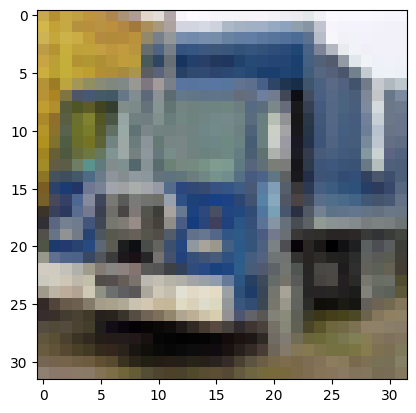

In [ ]:
index = 14
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)